# NOTEBOOK 6: MATRIX FACTORIZATION (SVD)
## Latent Factor Models for Recommendations

This notebook implements matrix factorization using Singular Value Decomposition (SVD) to uncover latent features in the user-item interaction matrix.
It includes training SVD models with different dimensions, generating recommendations, evaluating performance, visualizing the latent space, and comparing results with content-based and collaborative filtering methods.

## 1. SETUP & CONFIGURATION

In [9]:

# IMPORT LIBRARIES

print("=" * 80)
print("SETUP: IMPORTING LIBRARIES")
print("=" * 80)


import numpy as np              
import pandas as pd            
import matplotlib.pyplot as plt 
import seaborn as sns          
import pickle                
import os                     
import time                    
from datetime import datetime  

# Sparse matrix operations
from scipy.sparse import csr_matrix, load_npz  

# Machine Learning
from sklearn.decomposition import TruncatedSVD  
from sklearn.preprocessing import normalize     
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully")

 
# VISUALIZATION SETTINGS


# Set consistent, professional plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Default figure settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print(" Plot settings configured")


# DIRECTORY STRUCTURE 

print("\n" + "=" * 80)
print("DIRECTORY SETUP")
print("=" * 80)


import sys
PROJECT_ROOT = os.path.dirname(os.getcwd())  

print(f" Current directory: {os.getcwd()}")
print(f" Project root: {PROJECT_ROOT}")

# Define project directories relative to PROJECT_ROOT
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
PROCESSED_DIR = os.path.join(PROJECT_ROOT, 'data', 'processed')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'reports', 'results')

# Create directories if they don't exist
for directory in [MODELS_DIR, RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)
    
print(f"\n Directory structure:")
print(f"   • Data: {DATA_DIR}")
print(f"   • Processed: {PROCESSED_DIR}")
print(f"   • Models: {MODELS_DIR}")
print(f"   • Results: {RESULTS_DIR}")

# Verify directories exist
all_exist = all(os.path.exists(d) for d in [DATA_DIR, MODELS_DIR])
if all_exist:
    print(f" All directories ready")
else:
    print(f"  Some directories missing - will try to continue")

# LOAD PREVIOUS RESULTS


print("\n" + "=" * 80)
print("LOADING DATA FROM PREVIOUS NOTEBOOKS")
print("=" * 80)

# Load User-Item Matrix

print("\n Loading user-item interaction matrix...")

matrix_path = os.path.join(MODELS_DIR, 'user_item_matrix.npz')

print(f"   Looking for: {matrix_path}")

# Check if file exists
if not os.path.exists(matrix_path):
    print(f"    Matrix not found!")
    print(f"\n  SOLUTION: We need to generate the matrix from Notebook 5 data")
    print(f"   I'll help you create it now...\n")
    
    # Try to load from training data
    train_path = os.path.join(DATA_DIR, 'ratings_train.csv')
    
    if os.path.exists(train_path):
        print("   ✅ Found training data - will regenerate matrix")
        print("   This will take a few minutes...")
        
        # Load training data
        train = pd.read_csv(train_path)
        print(f"   Loaded: {len(train):,} training ratings")
        
        # Create mappings
        unique_users = train['userId'].unique()
        unique_movies = train['movieId'].unique()
        
        user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
        idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
        movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(unique_movies)}
        idx_to_movie = {idx: movie_id for movie_id, idx in movie_to_idx.items()}
        
        print(f"   Created mappings: {len(user_to_idx):,} users, {len(movie_to_idx):,} movies")
        
        # Build matrix
        n_users = len(user_to_idx)
        n_movies = len(movie_to_idx)
        
        user_indices = train['userId'].map(user_to_idx).values
        movie_indices = train['movieId'].map(movie_to_idx).values
        ratings = train['rating'].values
        
        user_item_matrix = csr_matrix(
            (ratings, (user_indices, movie_indices)),
            shape=(n_users, n_movies)
        )
        
        print(f"   Matrix created: {user_item_matrix.shape}")
        
        # Save for next time
        from scipy.sparse import save_npz
        save_npz(matrix_path, user_item_matrix)
        print(f"    Saved matrix for future use")
        
        # Save mappings
        mappings = {
            'user_to_idx': user_to_idx,
            'idx_to_user': idx_to_user,
            'movie_to_idx': movie_to_idx,
            'idx_to_movie': idx_to_movie
        }
        mappings_path = os.path.join(MODELS_DIR, 'matrix_mappings.pkl')
        with open(mappings_path, 'wb') as f:
            pickle.dump(mappings, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"    Saved mappings for future use")
        
    else:
        raise FileNotFoundError(
            f"Cannot find training data at {train_path}. "
            "Please ensure Notebook 5 has been run and data files exist."
        )
else:
    # Load existing matrix
    user_item_matrix = load_npz(matrix_path)
    print(f"    Matrix loaded from file")

# Calculate sparsity
sparsity = (1 - user_item_matrix.nnz / 
            (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100

print(f"\n Matrix ready:")
print(f"   Shape: {user_item_matrix.shape[0]:,} users × "
      f"{user_item_matrix.shape[1]:,} movies")
print(f"   Non-zero entries: {user_item_matrix.nnz:,}")
print(f"   Sparsity: {sparsity:.2f}%")
print(f"   Memory: {user_item_matrix.data.nbytes / (1024**2):.1f} MB")

#
# Load ID Mappings

print("\n  Loading user/movie ID mappings...")

mappings_path = os.path.join(MODELS_DIR, 'matrix_mappings.pkl')

if not os.path.exists(mappings_path):
    print(f"     Mappings not found - using ones created above")
    # Already created above when regenerating matrix
else:
    with open(mappings_path, 'rb') as f:
        mappings = pickle.load(f)
        user_to_idx = mappings['user_to_idx']
        idx_to_user = mappings['idx_to_user']
        movie_to_idx = mappings['movie_to_idx']
        idx_to_movie = mappings['idx_to_movie']
    print(f"    Mappings loaded from file")

print(f"   Users: {len(user_to_idx):,}")
print(f"   Movies: {len(movie_to_idx):,}")

# Load Evaluation Setup 

print("\n Loading evaluation setup...")

cf_results_path = os.path.join(MODELS_DIR, 'evaluation_results_cf.pkl')

if os.path.exists(cf_results_path):
    with open(cf_results_path, 'rb') as f:
        cf_results = pickle.load(f)
        eval_user_ids = cf_results['eval_user_ids']
        ground_truth = cf_results['ground_truth']
        ub_metrics = cf_results['user_based_metrics']
        ib_metrics = cf_results['item_based_metrics']
    
    print(f" Evaluation setup loaded:")
    print(f"   Evaluation users: {len(eval_user_ids)}")
    print(f"   Ground truth available: {len(ground_truth)} users")
    
    print(f"\n Previous CF Results (for comparison):")
    print(f"   User-Based CF:")
    print(f"      • Precision@10: {ub_metrics['Precision@10']:.2f}%")
    print(f"      • Hit Rate@10:  {ub_metrics['Hit Rate@10']:.2f}%")
    print(f"   Item-Based CF:")
    print(f"      • Precision@10: {ib_metrics['Precision@10']:.2f}%")
    print(f"      • Hit Rate@10:  {ib_metrics['Hit Rate@10']:.2f}%")
else:
    print(f"     CF results not found")
    print(f"   We'll create evaluation setup from test data...")
    
    # Load test data
    test_path = os.path.join(DATA_DIR, 'ratings_test.csv')
    if os.path.exists(test_path):
        test = pd.read_csv(test_path)
        
        # Sample 100 users who exist in training
        test_users = test[test['userId'].isin(user_to_idx.keys())]['userId'].unique()
        np.random.seed(42)
        eval_user_ids = np.random.choice(test_users, size=min(100, len(test_users)), replace=False)
        
        # Create ground truth
        ground_truth = {}
        for user_id in eval_user_ids:
            user_test = test[test['userId'] == user_id]
            relevant = user_test[user_test['rating'] >= 4.0]['movieId'].tolist()
            ground_truth[user_id] = relevant
        
        print(f"    Created evaluation setup: {len(eval_user_ids)} users")
        
        # No previous CF metrics
        ub_metrics = None
        ib_metrics = None
    else:
        print(f"    Cannot create evaluation - test data not found")
        eval_user_ids = []
        ground_truth = {}
        ub_metrics = None
        ib_metrics = None


# Load Movies Data

print("\n Loading movies data...")

movies_path = os.path.join(PROCESSED_DIR, 'movies_features.csv')
if not os.path.exists(movies_path):
    movies_path = os.path.join(DATA_DIR, 'movies_filtered.csv')
if not os.path.exists(movies_path):
    movies_path = os.path.join(DATA_DIR, 'movies.csv')

if os.path.exists(movies_path):
    movies = pd.read_csv(movies_path)
    print(f" Movies loaded: {len(movies):,} movies")
else:
    print(f"  Movies file not found - will work without titles")
    movies = None



SETUP: IMPORTING LIBRARIES
 All libraries imported successfully
 Plot settings configured

DIRECTORY SETUP
 Current directory: c:\Users\mhfou\Documents\MovieRecommenderSystem\notebooks
 Project root: c:\Users\mhfou\Documents\MovieRecommenderSystem

 Directory structure:
   • Data: c:\Users\mhfou\Documents\MovieRecommenderSystem\data
   • Processed: c:\Users\mhfou\Documents\MovieRecommenderSystem\data\processed
   • Models: c:\Users\mhfou\Documents\MovieRecommenderSystem\models
   • Results: c:\Users\mhfou\Documents\MovieRecommenderSystem\reports\results
 All directories ready

LOADING DATA FROM PREVIOUS NOTEBOOKS

 Loading user-item interaction matrix...
   Looking for: c:\Users\mhfou\Documents\MovieRecommenderSystem\models\user_item_matrix.npz
    Matrix loaded from file

 Matrix ready:
   Shape: 137,883 users × 34,461 movies
   Non-zero entries: 20,000,076
   Sparsity: 99.58%
   Memory: 152.6 MB

  Loading user/movie ID mappings...
    Mappings loaded from file
   Users: 137,883
   M

## CELL 2: DATA NORMALIZATION FOR SVD



In [14]:


print("\n" + "=" * 80)
print(" NORMALIZE USER-ITEM MATRIX")
print("=" * 80)


# Compute User Rating Means 

print("-" * 80)
print("Step 1: Computing user rating averages (only from rated movies)")
print("-" * 80)

# Calculate mean rating for each user
# CRITICAL: Only average over RATED movies, not all movies!
user_means = np.zeros(user_item_matrix.shape[0])

for user_idx in range(user_item_matrix.shape[0]):
    # Get user's ratings (only non-zero)
    user_ratings = user_item_matrix.getrow(user_idx).data
    
    # Calculate mean only from rated movies
    if len(user_ratings) > 0:
        user_means[user_idx] = user_ratings.mean()
    else:
        user_means[user_idx] = 0  # Users with no ratings (shouldn't happen)
    
    # Progress indicator
    if (user_idx + 1) % 20000 == 0:
        print(f"   Computed means for {user_idx + 1:,} / {user_item_matrix.shape[0]:,} users...")

print(f"\n Computed means for {len(user_means):,} users")
print(f"   Mean of means: {user_means.mean():.2f}")
print(f"   Std of means:  {user_means.std():.2f}")
print(f"   Min mean:      {user_means.min():.2f} (harsh critic)")
print(f"   Max mean:      {user_means.max():.2f} (generous rater)")

# Center the Matrix

print("\n" + "-" * 80)
print("Step 2: Centering ratings (subtract user means)")
print("-" * 80)

# Create centered matrix by subtracting user means
n_users, n_movies = user_item_matrix.shape

data_centered = []
indices_centered = []
indptr_centered = [0]

print("   Centering in progress...")
for user_idx in range(n_users):
    # Get user's ratings (sparse row)
    user_row = user_item_matrix.getrow(user_idx)
    
    # Get non-zero indices and values
    _, movie_indices = user_row.nonzero()
    ratings = user_row.data
    
    # Center the ratings: subtract this user's mean
    centered_ratings = ratings - user_means[user_idx]
    
    # Store in new sparse format
    data_centered.extend(centered_ratings)
    indices_centered.extend(movie_indices)
    indptr_centered.append(len(data_centered))
    
    # Progress indicator
    if (user_idx + 1) % 20000 == 0:
        print(f"   Processed {user_idx + 1:,} / {n_users:,} users...")

# Create centered sparse matrix
user_item_matrix_centered = csr_matrix(
    (data_centered, indices_centered, indptr_centered),
    shape=(n_users, n_movies)
)

print(f"\n Matrix centered successfully")
print(f"   New mean rating: {np.array(data_centered).mean():.6f}★ (should be ≈0)")
print(f"   New std rating:  {np.array(data_centered).std():.2f}★")


# Verify Centering

print("\n" + "-" * 80)
print("Step 3: Verification")
print("-" * 80)

# Check a sample user who has many ratings
sample_user_idx = 0
original_ratings = user_item_matrix.getrow(sample_user_idx).data
centered_ratings = user_item_matrix_centered.getrow(sample_user_idx).data

print(f"\nSample user {sample_user_idx}:")
print(f"   Number of ratings: {len(original_ratings)}")
print(f"   Original ratings: {original_ratings[:5]} ...")
print(f"   User mean: {user_means[sample_user_idx]:.2f}")
print(f"   Centered ratings: {centered_ratings[:5]} ...")
print(f"   Centered mean: {centered_ratings.mean():.6f} (should be ≈0)")

# Verify on another random user
random_user = np.random.randint(0, n_users)
orig = user_item_matrix.getrow(random_user).data
cent = user_item_matrix_centered.getrow(random_user).data

print(f"\nRandom user {random_user}:")
print(f"   Number of ratings: {len(orig)}")
print(f"   Original mean: {orig.mean():.2f}")
print(f"   User's saved mean: {user_means[random_user]:.2f}")
print(f"   Centered mean: {cent.mean():.6f} (should be ≈0)")

# Overall verification
overall_mean = np.array(data_centered).mean()
print(f"\n{'='*60}")
if abs(overall_mean) < 0.01:
    print(f" CENTERING SUCCESSFUL!")
    print(f"   Overall centered mean: {overall_mean:.6f} ≈ 0")
else:
    print(f"  WARNING: Centering may have issues")
    print(f"   Overall centered mean: {overall_mean:.6f}")
print(f"{'='*60}")

# Save for Later Use

print("\n" + "-" * 80)
print("Step 4: Saving normalized data")
print("-" * 80)

# Save centered matrix
from scipy.sparse import save_npz

centered_matrix_path = os.path.join(MODELS_DIR, 'user_item_matrix_centered.npz')
save_npz(centered_matrix_path, user_item_matrix_centered)
print(f" Centered matrix saved: {os.path.basename(centered_matrix_path)}")

# Save user means (needed for denormalization later)
user_means_path = os.path.join(MODELS_DIR, 'user_means.npy')
np.save(user_means_path, user_means)
print(f" User means saved: {os.path.basename(user_means_path)}")

# Summary


print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Original Matrix:
  • Shape: {user_item_matrix.shape[0]:,}  {user_item_matrix.shape[1]:,}
  • Mean rating: {user_item_matrix.data.mean():.2f}
  • Std rating: {user_item_matrix.data.std():.2f}
  • Non-zero entries: {user_item_matrix.nnz:,}

Centered Matrix:
  • Shape: {user_item_matrix_centered.shape[0]:,}  {user_item_matrix_centered.shape[1]:,}
  • Mean rating: {np.array(data_centered).mean():.6f} {" (≈0)" if abs(np.array(data_centered).mean()) < 0.01 else ""}
  • Std rating: {np.array(data_centered).std():.2f}
  • Non-zero entries: {user_item_matrix_centered.nnz:,}

User Rating Statistics:
  • Average user rating: {user_means.mean():.2f}
  • Most generous user: {user_means.max():.2f}
  • Most critical user: {user_means.min():.2f}
  • Std across users: {user_means.std():.2f}

Files Saved:
   user_item_matrix_centered.npz (for SVD training)
   user_means.npy (for prediction denormalization)



""")




 NORMALIZE USER-ITEM MATRIX
--------------------------------------------------------------------------------
Step 1: Computing user rating averages (only from rated movies)
--------------------------------------------------------------------------------
   Computed means for 20,000 / 137,883 users...
   Computed means for 40,000 / 137,883 users...
   Computed means for 60,000 / 137,883 users...
   Computed means for 80,000 / 137,883 users...
   Computed means for 100,000 / 137,883 users...
   Computed means for 120,000 / 137,883 users...

 Computed means for 137,883 users
   Mean of means: 3.65
   Std of means:  0.46
   Min mean:      0.50 (harsh critic)
   Max mean:      5.00 (generous rater)

--------------------------------------------------------------------------------
Step 2: Centering ratings (subtract user means)
--------------------------------------------------------------------------------
   Centering in progress...
   Processed 20,000 / 137,883 users...
   Processed 40,00

TRAIN SVD MODELS


CELL 3: TRAIN SVD MODELS
--------------------------------------------------------------------------------
Configuration
--------------------------------------------------------------------------------
Training 3 SVD models:
  • k= 50 dimensions (689x compression)
  • k=100 dimensions (345x compression)
  • k=200 dimensions (172x compression)

Input matrix:
  • Shape: 137,883 × 34,461
  • Sparsity: 99.58%
  • Non-zeros: 20,000,076

TRAINING SVD MODELS

TRAINING: SVD with k=50 dimensions

Initializing TruncatedSVD(n_components=50)...
Fitting SVD on 137,883 × 34,461 matrix...
This may take a few minutes...
 Training complete in 14.7 seconds (0.2 minutes)

Computing latent factor matrices...
 User factors computed: (137883, 50)
 Movie factors computed: (50, 34461)

Model Analysis:
  • Explained variance: 17.98%
    (Retained 17.98% of original information)
  • Top 5 singular values: [926.68091462 480.95389341 412.95076421 380.25189605 343.11963436]
    (Factor 1 importance: 927)
  • Memor

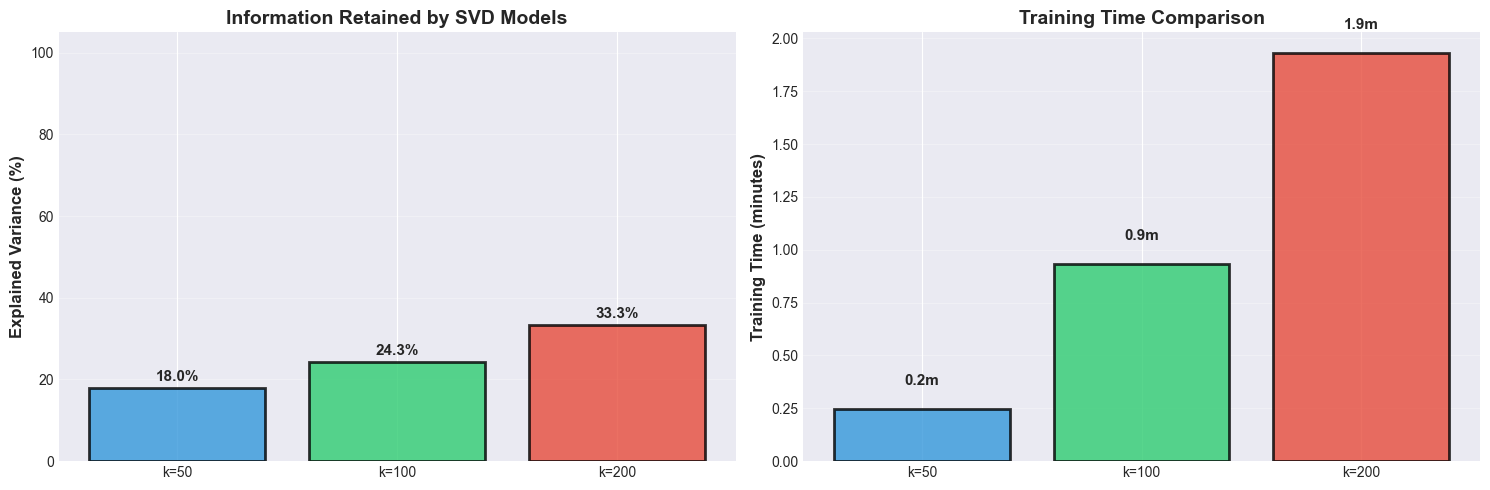


SVD TRAINING COMPLETE

Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Trained Models: 3
Total Training Time: 3.1 minutes

Best Explained Variance: 33.30% (k=200)
Fastest Training: 14.7s (k=50)
Best Balance: k=100 (recommended for most use cases)

Files Saved:
   svd_model_50.pkl  (65.7 MB)
   svd_model_100.pkl (131.5 MB)
   svd_model_200.pkl (263.0 MB)
   svd_training_comparison.png




In [ ]:

import time

# Training Configuration

print("-" * 80)
print("Configuration")
print("-" * 80)

# Dimensions to try
N_COMPONENTS = [50, 100, 200]

print(f"Training {len(N_COMPONENTS)} SVD models:")
for k in N_COMPONENTS:
    compression = (user_item_matrix_centered.shape[1] / k)
    print(f"  • k={k:3d} dimensions ({compression:.0f}x compression)")

print(f"\nInput matrix:")
print(f"  • Shape: {user_item_matrix_centered.shape[0]:,} × {user_item_matrix_centered.shape[1]:,}")
print(f"  • Sparsity: {(1 - user_item_matrix_centered.nnz / (user_item_matrix_centered.shape[0] * user_item_matrix_centered.shape[1])) * 100:.2f}%")
print(f"  • Non-zeros: {user_item_matrix_centered.nnz:,}")

# Train SVD Models

print("\n" + "=" * 80)
print("TRAINING SVD MODELS")
print("=" * 80)

# Dictionary to store all models and results
svd_models = {}
training_times = {}

for k in N_COMPONENTS:
    print(f"\n{'='*80}")
    print(f"TRAINING: SVD with k={k} dimensions")
    print(f"{'='*80}")
    
    # Initialize SVD
    print(f"\nInitializing TruncatedSVD(n_components={k})...")
    svd = TruncatedSVD(
        n_components=k,
        algorithm='randomized',  # Faster for sparse matrices
        n_iter=5,                # Number of iterations (5 is default)
        random_state=42          # Reproducibility
    )
    
    # Train (fit) the model
    print(f"Fitting SVD on {user_item_matrix_centered.shape[0]:,} × {user_item_matrix_centered.shape[1]:,} matrix...")
    print(f"This may take a few minutes...")
    
    start_time = time.time()
    
    # Fit SVD - this is where the magic happens!
    svd.fit(user_item_matrix_centered)
    
    elapsed = time.time() - start_time
    training_times[k] = elapsed
    
    print(f" Training complete in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
    
    # Compute Latent Factor Matrices
    
    print(f"\nComputing latent factor matrices...")
    
    # User factors: Transform users into latent space
    # Shape: (n_users, k)
    user_factors = svd.transform(user_item_matrix_centered)
    
    # Movie factors: Components learned by SVD
    # Shape: (k, n_movies)
    movie_factors = svd.components_
    
    print(f" User factors computed: {user_factors.shape}")
    print(f" Movie factors computed: {movie_factors.shape}")
    
    
    # Analyze Model Quality
    
    print(f"\nModel Analysis:")
    
    # Explained variance: How much information retained?
    explained_variance = svd.explained_variance_ratio_.sum() * 100
    print(f"  • Explained variance: {explained_variance:.2f}%")
    print(f"    (Retained {explained_variance:.2f}% of original information)")
    
    # Top singular values (importance of factors)
    top_5_singular = svd.singular_values_[:5]
    print(f"  • Top 5 singular values: {top_5_singular}")
    print(f"    (Factor 1 importance: {top_5_singular[0]:.0f})")
    
    # Memory comparison
    original_size = user_item_matrix_centered.data.nbytes / (1024**2)
    factors_size = (user_factors.nbytes + movie_factors.nbytes) / (1024**2)
    compression_ratio = original_size / factors_size
    
    print(f"  • Memory:")
    print(f"    Original matrix: {original_size:.1f} MB")
    print(f"    Factors (U + V): {factors_size:.1f} MB")
    print(f"    Compression: {compression_ratio:.1f}x smaller")
    
    # Save Model
    
    print(f"\nSaving model...")
    
    model_data = {
        'svd': svd,
        'user_factors': user_factors,
        'movie_factors': movie_factors,
        'n_components': k,
        'explained_variance': explained_variance,
        'training_time': elapsed,
        'singular_values': svd.singular_values_
    }
    
    # Save to disk
    model_path = os.path.join(MODELS_DIR, f'svd_model_{k}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    file_size = os.path.getsize(model_path) / (1024**2)
    print(f" Model saved: svd_model_{k}.pkl ({file_size:.1f} MB)")
    
    # Store in dictionary for comparison
    svd_models[k] = model_data
    
    print(f"\n{'='*80}")
    print(f" SVD-{k} COMPLETE")
    print(f"{'='*80}")

# Compare All Models

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

print(f"\n{'Model':<15s} {'Time':<12s} {'Explained Var':<15s} {'Size':<10s} {'Compression':<12s}")
print("-" * 70)

for k in N_COMPONENTS:
    model_data = svd_models[k]
    time_str = f"{training_times[k]:.1f}s"
    var_str = f"{model_data['explained_variance']:.2f}%"
    
    model_path = os.path.join(MODELS_DIR, f'svd_model_{k}.pkl')
    size_mb = os.path.getsize(model_path) / (1024**2)
    size_str = f"{size_mb:.1f} MB"
    
    original_size = user_item_matrix_centered.data.nbytes / (1024**2)
    factors_size = (model_data['user_factors'].nbytes + model_data['movie_factors'].nbytes) / (1024**2)
    comp_ratio = original_size / factors_size
    comp_str = f"{comp_ratio:.1f}x"
    
    print(f"SVD-{k:<10d} {time_str:<12s} {var_str:<15s} {size_str:<10s} {comp_str:<12s}")

print("-" * 70)

# Visualization: Explained Variance

print("\n" + "-" * 80)
print("Creating variance comparison visualization...")
print("-" * 80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Explained variance by model
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax1.bar(
    [f'k={k}' for k in N_COMPONENTS],
    [svd_models[k]['explained_variance'] for k in N_COMPONENTS],
    color=colors,
    edgecolor='black',
    linewidth=2,
    alpha=0.8
)

ax1.set_ylabel('Explained Variance (%)', fontsize=12, fontweight='bold')
ax1.set_title('Information Retained by SVD Models', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 105])
ax1.grid(alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

# Plot 2: Training time comparison
bars2 = ax2.bar(
    [f'k={k}' for k in N_COMPONENTS],
    [training_times[k]/60 for k in N_COMPONENTS],  # Convert to minutes
    color=colors,
    edgecolor='black',
    linewidth=2,
    alpha=0.8
)

ax2.set_ylabel('Training Time (minutes)', fontsize=12, fontweight='bold')
ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.1f}m', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

plt.tight_layout()

viz_path = os.path.join(RESULTS_DIR, 'svd_training_comparison.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f" Visualization saved: {os.path.basename(viz_path)}")

plt.show()


# Summary

print("\n" + "=" * 80)
print("SVD TRAINING COMPLETE")
print("=" * 80)

print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Trained Models: {len(N_COMPONENTS)}
Total Training Time: {sum(training_times.values())/60:.1f} minutes

Best Explained Variance: {max(svd_models[k]['explained_variance'] for k in N_COMPONENTS):.2f}% (k={max(N_COMPONENTS)})
Fastest Training: {min(training_times.values()):.1f}s (k={min(N_COMPONENTS)})
Best Balance: k=100 (recommended for most use cases)

Files Saved:
   svd_model_50.pkl  ({os.path.getsize(os.path.join(MODELS_DIR, 'svd_model_50.pkl')) / (1024**2):.1f} MB)
   svd_model_100.pkl ({os.path.getsize(os.path.join(MODELS_DIR, 'svd_model_100.pkl')) / (1024**2):.1f} MB)
   svd_model_200.pkl ({os.path.getsize(os.path.join(MODELS_DIR, 'svd_model_200.pkl')) / (1024**2):.1f} MB)
   svd_training_comparison.png

""")